In [103]:
import cv2
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import albumentations as A

import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import albumentations as A

from albumentations.pytorch import ToTensorV2
from PIL import Image
from plotly.subplots import make_subplots
from tqdm.notebook import tqdm
from torchvision.models import resnet50, ResNet50_Weights
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from tqdm.notebook import trange

In [ ]:
!pip install torchmetrics
!pip install pytorch-lightning

In [107]:
CLOUD_DUMP_PATH = 'data/cloud_dump/'
CLOUD_DUMP_TOUCHED_PATH = 'data/cloud_dump/is_touched_20221006_1815.csv'
ROBOT_DUMP_PATH = 'data/robot_dump/'
CONTENT = 'data/meda_content'

## Препроцессинг данных

In [ ]:
def get_cloud_data(path):
    dfs = []
    json_paths = [path for path in [x for x in os.walk(path)][0][2] if '.json' in path]
    for name in json_paths:
        with open(os.path.join(path, name)) as f:
            dfs.append(pd.read_json(f).set_index('id'))
    return pd.concat(dfs, axis=0)
    
def get_robot_data(path):
    dfs = []
    json_paths = [path for path in [x for x in os.walk(path)][0][2] if '.json' in path]
    for name in json_paths:
        with open(os.path.join(path, name)) as f:
            dfs.append(pd.DataFrame.from_dict(json.load(f)['data']).set_index('id'))
    return pd.concat(dfs, axis=0)

def merge_data(cloud_data, robot_data, columns=['palletPlaceImageUri', 'scanResult', 'location', 'addDate']):
    assert(set(columns).issubset(cloud_data.columns))
    assert(set(columns).issubset(robot_data.columns))
    to_concat = [cloud_data[columns], robot_data[columns]]
    return pd.concat(to_concat, axis=0)

def get_raw_data(cloud_data_path, robot_data_path):
    cloud_data = get_cloud_data(cloud_data_path)
    robot_data = get_robot_data(robot_data_path)
    robot_data.rename(columns={'createdDatetime': 'addDate'}, inplace=True)
    return merge_data(cloud_data, robot_data)

In [ ]:
def get_jpeg_paths(content_folder):
    jpeg_paths = {}
    for folder in os.walk(content_folder):
        for path in folder[2]:
            if '.jpeg' in path:
                jpeg_paths[path] = os.path.join(folder[0], path)
    return jpeg_paths

def replace_jpeg_paths(data, jpeg_paths, column='jpeg_path'):
    assert(column in data.columns)
    data[column] = data.apply(lambda x: jpeg_paths[x[column]] if x[column] in jpeg_paths else np.NaN, axis=1)
    return data

def preprocess(raw_data, touched_data, content_folder):
    raw_data.rename(columns={
        'palletPlaceImageUri': 'jpeg_path',
        'scanResult': 'pallet',
    }, inplace=True)
    jpeg_paths = get_jpeg_paths(content_folder)
    data = pd.merge(raw_data, touched_data, how='left',on=['pallet','location'])
    data = replace_jpeg_paths(data, jpeg_paths)
    return data

In [ ]:
def print_img(path):
    image = cv2.imread(path)
    plt.imshow(image)
    plt.show()

In [ ]:
raw_data = get_raw_data(CLOUD_DUMP_PATH, ROBOT_DUMP_PATH)
touched_data = pd.read_csv(CLOUD_DUMP_TOUCHED_PATH, names=['pallet','location','is_touched'])

In [ ]:
data = preprocess(raw_data, touched_data, CONTENT)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


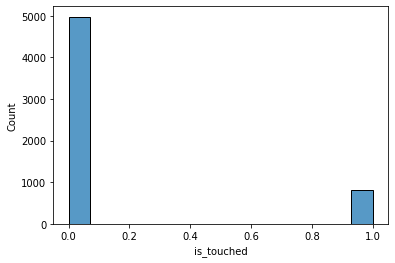

In [ ]:
import seaborn as sns
data = data.dropna()
data['is_touched'] = data['is_touched'].astype(int)
sns.histplot(data['is_touched'])

## Вовин код для уникальных палет + аугментация

In [ ]:
pallets = np.unique(data['pallet'])
train_pallets, test_pallets = train_test_split(pallets, test_size=0.2, random_state=42)
data_train, data_test = data.loc[data['pallet'].isin(train_pallets)], data.loc[data['pallet'].isin(test_pallets)]

In [ ]:
set(data_train.pallet) & set(data_test.pallet)

set()

In [ ]:
class PackageDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):        
        img_jpeg_path = self.dataset.iloc[idx]['jpeg_path']
        is_touched = self.dataset.iloc[idx]['is_touched']
        
        image = np.array(Image.open(img_jpeg_path))
        
        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, is_touched

In [ ]:
test_transform = A.Compose(
    [
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), 
        A.Resize(width=208, height=608),
        ToTensorV2()
    ]
)

train_transform = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.Resize(width=208, height=608),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [ ]:
train_dataset = PackageDataset(data_train, train_transform)
test_dataset = PackageDataset(data_test, test_transform)

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, shuffle=True,
    batch_size=16, num_workers=2
)

val_dataloader = torch.utils.data.DataLoader(
    test_dataset, shuffle=False,
    batch_size=16, num_workers=2
)

## Исходная модель by pytorch.lightning 

In [ ]:
import torch
import torchvision.transforms as transforms
from torch.nn import functional as F
from torch import nn
from torch.nn import *
import pytorch_lightning as pl
import torchvision
from torchvision.models import resnet50, ResNet50_Weights

class ImageClassifier(pl.LightningModule):
    def __init__(self, trunk=None, class_weight=None, learning_rate=1e-4):
        super().__init__()
        self.class_weight = class_weight
        self.trunk = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.trunk.fc = nn.Linear(2048, 2)
        self.learning_rate =  learning_rate

    def forward(self, x):
        return self.trunk(x)

    def predict_proba(self, x):
        probabilities = nn.functional.softmax(self.forward(x), dim=1)
        return probabilities

    def predict(self, x):
        return torch.max(self.forward(x), 1)[1]

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(),
                                      lr=self.learning_rate)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.CrossEntropyLoss(weight=self.class_weight)(y_hat, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.CrossEntropyLoss(weight=self.class_weight)(y_hat, y)
        pred = np.argmax(nn.functional.softmax(y_hat.cpu(), dim=1), axis=1)
        accuracy = np.mean(np.array(pred) == np.array(y.cpu()))
      
        self.log("val_loss", loss)
        self.log("val_acc", accuracy)


In [ ]:
import tqdm.auto as tqdm

def evaluate_model_val(model, loader):
    model.eval()
    predictions = []
    labels = []
    with torch.no_grad():
        for x, y in tqdm.tqdm(loader):
            prediction = model.predict(x.to(model.device)).cpu().numpy()
            predictions += list(prediction)
            labels += list(y.numpy())
    return labels, predictions

### Проверка чекпоинта на аугментированных данных

In [ ]:
model = ImageClassifier(learning_rate=1e-4)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
PATH = 'data/model.ckpt'
checkpoint = torch.load(PATH)
checkpoint.keys()

dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers'])

In [ ]:
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [ ]:
labels, predictions = evaluate_model_val(model, val_dataloader)

  0%|          | 0/69 [00:00<?, ?it/s]

In [ ]:
print("Dummy Baseline accuracy: ", np.mean(0 == np.array(labels)))
print("Baseline accuracy: ", np.mean(np.array(predictions) == np.array(labels)))

Dummy Baseline accuracy:  0.908675799086758
Baseline accuracy:  0.9899543378995433


Результат все еще слишком хорош

### Добавляем callback для метрик

In [ ]:
from matplotlib.collections import TriMesh
from pytorch_lightning.callbacks import Callback

class GetCallback(Callback):

    def __init__(self):
        self.batch_loss = []
        self.train_loss = []
        self.val_loss = []
        self.val_acc = []

    def on_train_start(self, trainer, pl_module):
        print("Training is started!")
    def on_train_end(self, trainer, pl_module):
        print("Training is done.")
    def on_train_batch_end (self, trainer, pl_module, a, b, c):
        TM = trainer.logged_metrics
        self.batch_loss.append(TM['train_loss'].cpu())
    def on_validation_epoch_end(self, trainer, module):
        TM = trainer.logged_metrics
        self.val_loss.append(TM['val_loss'].cpu())
        self.val_acc.append(TM['val_acc'].cpu())
        clear_output(True)
        fig, ax = plt.subplots(1, 2, figsize=(16, 5))
        ax[0].plot(self.batch_loss)
        ax[0].set_title('training_loss')
        ax[1].plot(self.val_acc)
        ax[1].set_title('val_acc')
        plt.show()


### Тренируем модель на всем датасете (палеты разделены)

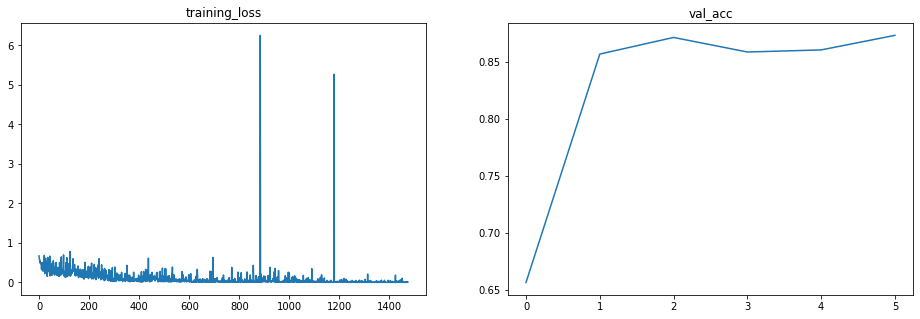

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


Training is done.


In [ ]:
callbacks = GetCallback()
model2 = ImageClassifier(learning_rate=1e-4)
trainer = pl.Trainer(
    callbacks=[callbacks],
    max_epochs=5,
    log_every_n_steps=1,
    gpus=-1)

trainer.fit(model2, train_dataloader, val_dataloader)

In [127]:
print('Dummy Baseline accuracy = ', 1 - len(data[data.is_touched == True])/len(data))

Dummy Baseline accuracy =  0.858103448275862


## Сэмплирование данных

In [ ]:
from sklearn.utils import shuffle
data_small = pd.concat([data[data.is_touched == False].sample(823), data[data.is_touched == True]])
data_small = shuffle(data_small)
pallets_small = np.unique(data_small['pallet'])
train_pallets_small, test_pallets_small = train_test_split(pallets_small, test_size=0.2, random_state=42)
data_train_small, data_test_small = data_small.loc[data_small['pallet'].isin(train_pallets_small)], data_small.loc[data_small['pallet'].isin(test_pallets_small)]

train_dataset_small = PackageDataset(data_train_small, train_transform)
test_dataset_small = PackageDataset(data_test_small, test_transform)

train_dataloader_small = torch.utils.data.DataLoader(
    train_dataset, shuffle=True,
    batch_size=16, num_workers=2
)

val_dataloader_small = torch.utils.data.DataLoader(
    test_dataset, shuffle=False,
    batch_size=16, num_workers=2
)

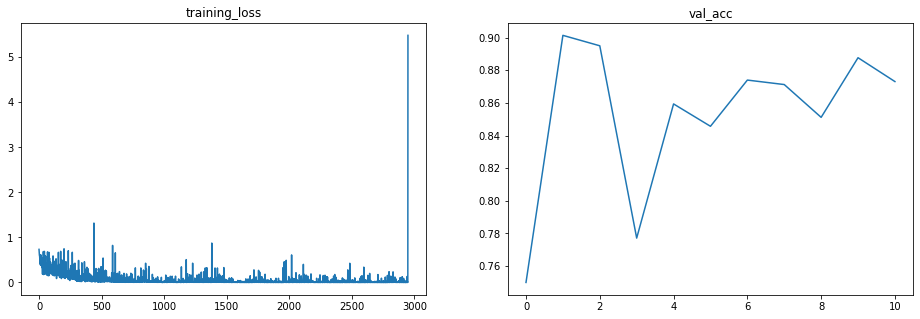

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Training is done.


In [ ]:
callbacks = GetCallback()
model3 = ImageClassifier(learning_rate=1e-4)
trainer = pl.Trainer(
    callbacks=[callbacks],
    max_epochs=10,
    log_every_n_steps=1,
    gpus=-1)

trainer.fit(model3, train_dataloader_small, val_dataloader_small)

In [128]:
print('Dummy Baseline accuracy = ', 1 - len(data_small[data_small.is_touched == True])/len(data_small))

Dummy Baseline accuracy =  0.5


Кажется, чему-то все таки учимся

### Теперь моделируем изначальную ситуацию, берем палеты в перемешку

In [ ]:
data_train_mixed, data_test_mixed = train_test_split(data_small, test_size=0.2, random_state=42)

In [111]:
train_dataset_mixed = PackageDataset(data_train_mixed, train_transform)
test_dataset_mixed = PackageDataset(data_test_mixed, test_transform)

train_dataloader_mixed = torch.utils.data.DataLoader(
    train_dataset_mixed, shuffle=True,
    batch_size=16, num_workers=2
)

val_dataloader_mixed = torch.utils.data.DataLoader(
    test_dataset_mixed, shuffle=False,
    batch_size=16, num_workers=2
)

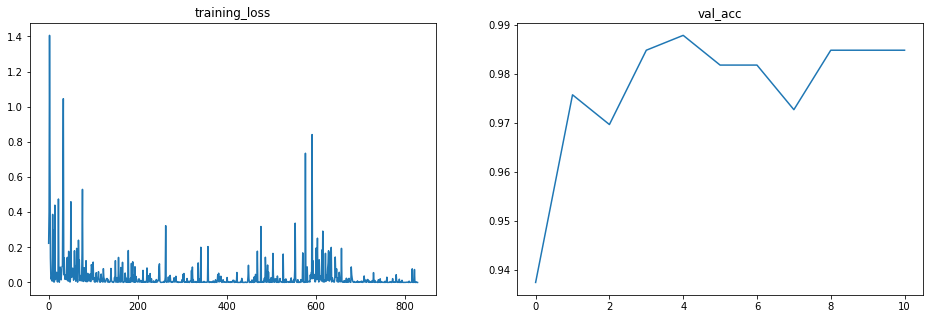

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Training is done.


In [113]:
callbacks = GetCallback()
model4 = ImageClassifier(learning_rate=1e-4)
trainer = pl.Trainer(
    callbacks=[callbacks],
    max_epochs=10,
    log_every_n_steps=1,
    gpus=-1)

trainer.fit(model3, train_dataloader_mixed, val_dataloader_mixed)

In [130]:
print('Dummy Baseline accuracy = ', 1 - len(data_small[data_small.is_touched == True])/len(data_small))

Dummy Baseline accuracy =  0.5


Кажется, предположение о переобучении на фотографих одинх и тех же палет класса 0 верно

In [132]:
p_touched = list(data[data.is_touched == True].pallet)
print(len(p_touched))
print(len(data[data.pallet.isin(p_touched)]))

823
823


Для класса 1 такого не происходит, так как все вскрытые палеты уникальны